In [1]:
%%time

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow as tf
from keras.utils import np_utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

CPU times: user 4.34 s, sys: 995 ms, total: 5.33 s
Wall time: 10.7 s


In [2]:
%%time
df = pd.read_csv("/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv")

CPU times: user 132 ms, sys: 22 ms, total: 154 ms
Wall time: 382 ms


In [3]:
%%time
df.head()

CPU times: user 89 µs, sys: 13 µs, total: 102 µs
Wall time: 108 µs


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
%%time
# Print two records from each class
df.sort_values(['Rating']).groupby('Rating').head(2)

CPU times: user 6.06 ms, sys: 181 µs, total: 6.24 ms
Wall time: 13.4 ms


,Review,Rating
11578,not good checked asked room track said dollars...,1
17628,terrible service ignorant staff reading great ...,1
20295,westin vs expedia booked expedia people reques...,2
2785,not repeat customer seeing positive reviews si...,2
8816,american hotel amsterdam based reviews trip ad...,3
14032,"good hotel, stayed mid-march 2004 pretty pleas...",3
18653,pretty good price husband stayed majestic 7 da...,4
18969,great style service stayed granados 83 october...,4
17134,hotel hotel seen like it.stayed hotel 7th feb ...,5
17132,"fabulous vacation, loved bahia principe, staff...",5


CPU times: user 376 ms, sys: 131 ms, total: 507 ms
Wall time: 311 ms


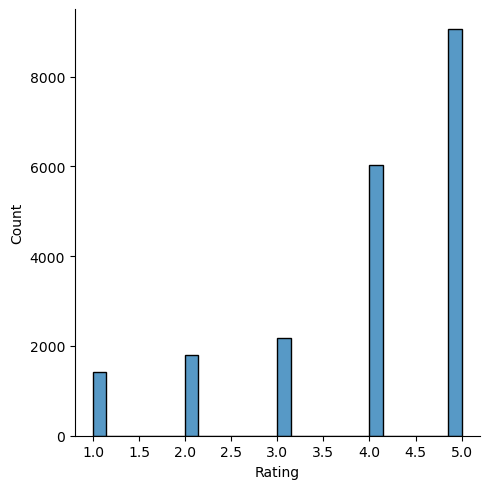

In [5]:
%%time
sns.displot(x="Rating", data=df)

In [6]:
%%time
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
embeded_reviews = embed(df['Review'])

CPU times: user 5.16 s, sys: 2.76 s, total: 7.92 s
Wall time: 9.88 s


In [7]:
%%time
embeded_reviews = embeded_reviews.numpy()
embeded_reviews

CPU times: user 4.08 ms, sys: 10.3 ms, total: 14.4 ms
Wall time: 17.3 ms


array([[ 0.20585983,  0.18637098, -0.15752402, ..., -0.09446388,
         0.5119964 , -0.01507805],
       [ 0.24491759,  0.6142323 , -0.15370034, ..., -0.3032439 ,
         0.6917187 , -0.12358426],
       [ 0.02124508,  0.526504  , -0.29576316, ..., -0.38237894,
         0.7460834 , -0.17340736],
       ...,
       [ 0.06914312,  0.29563522, -0.17144734, ..., -0.5006316 ,
         0.40495917, -0.11970636],
       [ 0.42421955,  1.0657966 , -0.12848336, ..., -0.24944922,
         0.85995495,  0.14251286],
       [ 0.16960734,  0.37283504, -0.05605148, ..., -0.07607687,
         0.53097796,  0.16431849]], dtype=float32)

In [8]:
%%time
encoder = LabelEncoder()
encoder.fit(df['Rating'])
encoded_Rating = encoder.transform(df['Rating'])
dummy_Rating = np_utils.to_categorical(encoded_Rating)

CPU times: user 1.89 ms, sys: 694 µs, total: 2.58 ms
Wall time: 2.51 ms


In [9]:
%%time
# Label encoding inverse to check whether the encoding happened correctly or not.
df['Rating_trans'] = np.argmax(dummy_Rating, axis=-1)

CPU times: user 1.73 ms, sys: 0 ns, total: 1.73 ms
Wall time: 1.79 ms


In [10]:
%%time
dummy_Rating

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


array([[0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [11]:
%%time
X_train, X_test, y_train, y_test = train_test_split(embeded_reviews, dummy_Rating, test_size=0.3, random_state=42)

inverse_transformed_y_test = np.argmax(y_test, axis=-1)

CPU times: user 5.57 ms, sys: 1.91 ms, total: 7.49 ms
Wall time: 8.13 ms


In [12]:
%%time
# summarize history for loss
def plot_model_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
# summarize history for accuracy
def plot_model_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Added custom callback function for the keras which we are implement so that we can trace the total training time elaspsed.
class TimingCallback(keras.callbacks.Callback):
  def __init__(self):
    self.logs=[]
  def on_epoch_begin(self, epoch, logs=None):
    self.starttime=time()
  def on_epoch_end(self, epoch, logs=None):
    self.logs.append(time()-self.starttime)
    
def calculate_total_correct_incorrect_prediction(confusion_matrix):
    array = []
    for i in range(0, confusion_matrix.shape[1]):
        temp = []
        temp2 = 0
        temp.append(i + 1)
        for j in range(0, confusion_matrix[i].shape[0]):
            if i == j:
                temp.append(confusion_matrix[i][j])
            else:
                temp2 += confusion_matrix[i][j]
        total = temp[1] + temp2
        temp.append(str(round((temp[1] / total) * 100, 2)) + '%') 
        temp.append(temp2)
        temp.append(str(round((temp2 / total) * 100, 2)) + '%') 
        array.append(temp)
    return pd.DataFrame(array, columns = ['Rating', 'Correct', 'Correct_Perc','Incorrect', 'InCorrect_Perc'])

CPU times: user 26 µs, sys: 0 ns, total: 26 µs
Wall time: 29.6 µs


In [13]:
%%time
q1_model_comparision = []

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.44 µs


In [14]:
%%time
model4 = keras.Sequential(name = 'Model-4')
model4.add(layers.InputLayer(input_shape=(128,)))

model4.add(layers.Dense(128, activation='relu', kernel_regularizer='l2'))
model4.add(layers.Dropout(0.4))
model4.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))
model4.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))

model4.add(layers.Dense(5, activation='softmax'))

model4.summary()

Model: "Model-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 29,253
Trainable params: 29,253
Non-trainable params: 0
_________________________________________________________________
CPU times: user 95.5 ms, sys: 5.66 ms, total: 101 ms
Wa

In [15]:
%%time
model4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

CPU times: user 19.6 ms, sys: 139 µs, total: 19.8 ms
Wall time: 18.1 ms


In [16]:
%%time
callback4 = TimingCallback()
history4 = model4.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_test, y_test), callbacks=[callback4])

Epoch 1/150
57/57 [==============================] - 6s 11ms/step - loss: 3.2408 - accuracy: 0.4332 - val_loss: 2.3537 - val_accuracy: 0.4356
Epoch 2/150
57/57 [==============================] - 0s 5ms/step - loss: 1.9411 - accuracy: 0.4808 - val_loss: 1.5959 - val_accuracy: 0.4967
Epoch 3/150
57/57 [==============================] - 0s 5ms/step - loss: 1.4647 - accuracy: 0.5096 - val_loss: 1.3314 - val_accuracy: 0.5267
Epoch 4/150
57/57 [==============================] - 0s 5ms/step - loss: 1.2828 - accuracy: 0.5237 - val_loss: 1.2137 - val_accuracy: 0.5288
Epoch 5/150
57/57 [==============================] - 0s 5ms/step - loss: 1.2085 - accuracy: 0.5336 - val_loss: 1.1697 - val_accuracy: 0.5363
Epoch 6/150
57/57 [==============================] - 0s 5ms/step - loss: 1.1728 - accuracy: 0.5349 - val_loss: 1.1499 - val_accuracy: 0.5452
Epoch 7/150
57/57 [==============================] - 0s 5ms/step - loss: 1.1565 - accuracy: 0.5396 - val_loss: 1.1380 - val_accuracy: 0.5226
Epoch 8/150


<-------------Model Loss Graph------------->


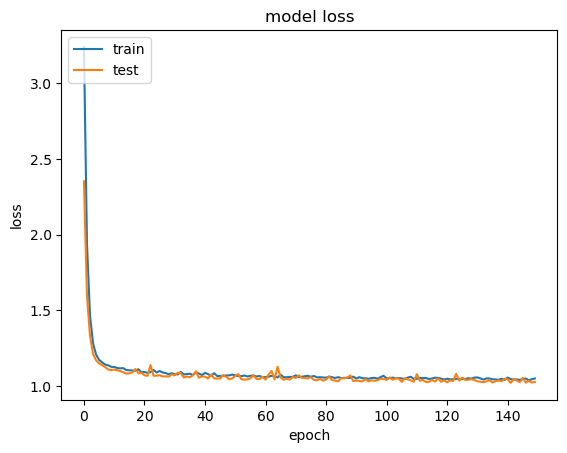

<-------------Model Accuracy Graph------------->


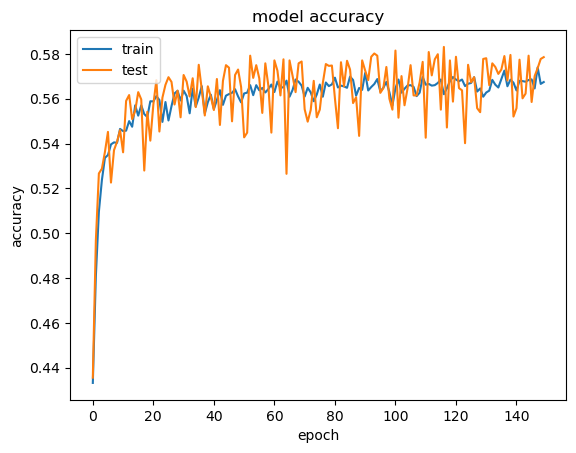

CPU times: user 698 ms, sys: 166 ms, total: 864 ms
Wall time: 601 ms


In [17]:
%%time
print('<-------------Model Loss Graph------------->')
plot_model_loss(history4)

print('<-------------Model Accuracy Graph------------->')
plot_model_accuracy(history4)

In [18]:
%%time
print('Total time taken in training the model: %.2f seconds' % (sum(callback4.logs)))

Total time taken in training the model: 49.85 seconds
CPU times: user 0 ns, sys: 736 µs, total: 736 µs
Wall time: 917 µs


193/193 [==============================] - 1s 3ms/step - loss: 1.0266 - accuracy: 0.5786

Test accuracy = 0.5785621404647827 
loss - 1.0265748500823975

193/193 [==============================] - 0s 2ms/step

Classification Report
               precision    recall  f1-score   support

           0       0.70      0.56      0.62       432
           1       0.41      0.42      0.41       523
           2       0.37      0.14      0.20       645
           3       0.47      0.44      0.46      1887
           4       0.67      0.82      0.74      2661

    accuracy                           0.58      6148
   macro avg       0.52      0.48      0.49      6148
weighted avg       0.56      0.58      0.56      6148


Confusion Matrix Display


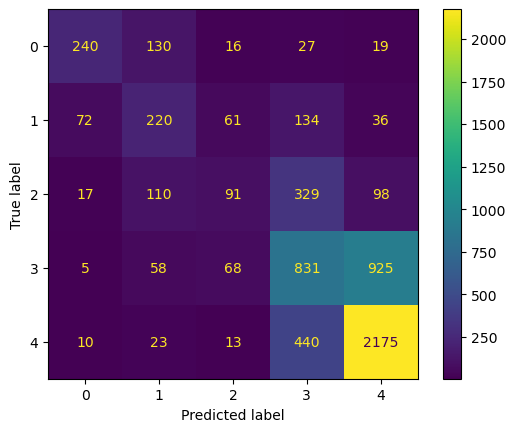

CPU times: user 1.58 s, sys: 211 ms, total: 1.79 s
Wall time: 1.66 s


In [19]:
%%time
loss4, acc4 = model4.evaluate(X_test, y_test)
print('\nTest accuracy = {} \nloss - {}\n'.format(acc4, loss4))
y_pred4 = np.argmax(model4.predict(X_test), axis=-1)
cm4 = classification_report(inverse_transformed_y_test, y_pred4)
print('\nClassification Report\n', cm4)
print('=====================================================\n')
confusion_matrix4 = confusion_matrix(inverse_transformed_y_test, y_pred4)
print('Confusion Matrix Display')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix4, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

In [20]:
%%time
q1_model_comparision.append(['Model-1', loss4, acc4])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


In [21]:
%%time
calculate_total_correct_incorrect_prediction(confusion_matrix4)

CPU times: user 1.43 ms, sys: 0 ns, total: 1.43 ms
Wall time: 1.39 ms


,Rating,Correct,Correct_Perc,Incorrect,InCorrect_Perc
0,1,240,55.56%,192,44.44%
1,2,220,42.07%,303,57.93%
2,3,91,14.11%,554,85.89%
3,4,831,44.04%,1056,55.96%
4,5,2175,81.74%,486,18.26%


In [22]:
%%time
print("Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%")


Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%
CPU times: user 92 µs, sys: 14 µs, total: 106 µs
Wall time: 160 µs


In [23]:
%%time
model5 = keras.Sequential(name = 'Model-5')
model5.add(layers.InputLayer(input_shape=(128,)))

model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dropout(0.1))
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(64, activation='relu'))

model5.add(layers.Dense(5, activation='softmax'))

model5.summary()

Model: "Model-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                                 
Total params: 29,253
Trainable params: 29,253
Non-trainable params: 0
_________________________________________________________________
CPU times: user 63.3 ms, sys: 1.79 ms, total: 65 ms
Wal

In [24]:
%%time
model5.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

CPU times: user 10.9 ms, sys: 967 µs, total: 11.8 ms
Wall time: 11.4 ms


In [25]:
%%time
callback5 = TimingCallback()
history5 = model5.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_test, y_test), callbacks=[callback5])

Epoch 1/150
57/57 [==============================] - 2s 8ms/step - loss: 1.2482 - accuracy: 0.4685 - val_loss: 1.0773 - val_accuracy: 0.5150
Epoch 2/150
57/57 [==============================] - 0s 5ms/step - loss: 1.0441 - accuracy: 0.5346 - val_loss: 0.9934 - val_accuracy: 0.5538
Epoch 3/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9934 - accuracy: 0.5570 - val_loss: 0.9803 - val_accuracy: 0.5579
Epoch 4/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9852 - accuracy: 0.5615 - val_loss: 0.9606 - val_accuracy: 0.5709
Epoch 5/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9631 - accuracy: 0.5679 - val_loss: 0.9571 - val_accuracy: 0.5649
Epoch 6/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9559 - accuracy: 0.5728 - val_loss: 0.9590 - val_accuracy: 0.5660
Epoch 7/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9459 - accuracy: 0.5777 - val_loss: 0.9865 - val_accuracy: 0.5486
Epoch 8/150
5

<-------------Model Accuracy Graph------------->


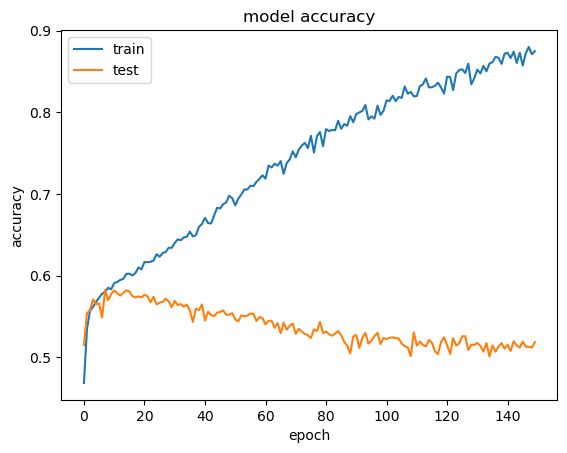

<-------------Model Loss Graph------------->


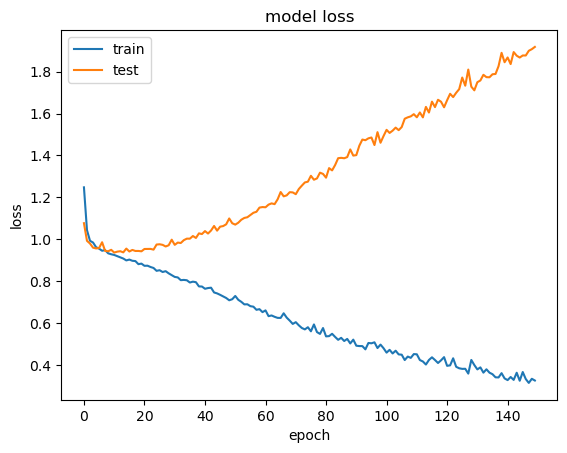

CPU times: user 686 ms, sys: 162 ms, total: 848 ms
Wall time: 579 ms


In [26]:
%%time
print('<-------------Model Accuracy Graph------------->')
plot_model_accuracy(history5)

print('<-------------Model Loss Graph------------->')
plot_model_loss(history5)

In [27]:
%%time
print('Total time taken in training the model: %.2f seconds' % (sum(callback5.logs)))

Total time taken in training the model: 44.26 seconds
CPU times: user 448 µs, sys: 62 µs, total: 510 µs
Wall time: 410 µs


193/193 [==============================] - 0s 2ms/step - loss: 1.9174 - accuracy: 0.5184

Test accuracy = 0.5183799862861633 
loss - 1.9173905849456787

193/193 [==============================] - 0s 1ms/step

Classification Report
               precision    recall  f1-score   support

           0       0.56      0.54      0.55       432
           1       0.32      0.33      0.32       523
           2       0.25      0.21      0.23       645
           3       0.43      0.41      0.42      1887
           4       0.65      0.70      0.68      2661

    accuracy                           0.52      6148
   macro avg       0.44      0.44      0.44      6148
weighted avg       0.51      0.52      0.51      6148


Confusion Matrix Display


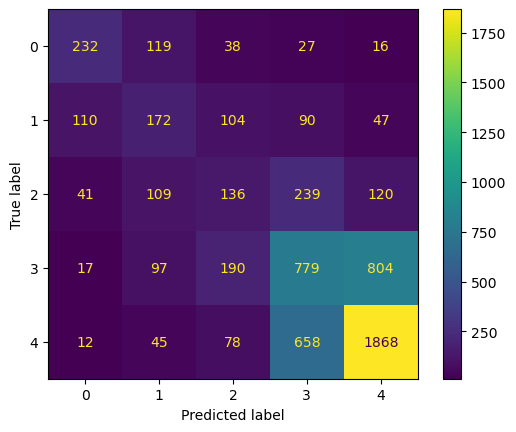

CPU times: user 1.47 s, sys: 193 ms, total: 1.66 s
Wall time: 1.58 s


In [28]:
%%time
loss5, acc5 = model5.evaluate(X_test, y_test)
print('\nTest accuracy = {} \nloss - {}\n'.format(acc5, loss5))
y_pred5 = np.argmax(model5.predict(X_test), axis=-1)
cm5 = classification_report(inverse_transformed_y_test, y_pred5)
print('\nClassification Report\n', cm5)
print('=====================================================\n')
confusion_matrix5 = confusion_matrix(inverse_transformed_y_test, y_pred5)
print('Confusion Matrix Display')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix5, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

In [29]:
%%time
q1_model_comparision.append(['Model-2', loss5, acc5])

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.54 µs


In [30]:
%%time
# ================================
# Classification report
#================================
calculate_total_correct_incorrect_prediction(confusion_matrix5)

CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 1.17 ms


,Rating,Correct,Correct_Perc,Incorrect,InCorrect_Perc
0,1,232,53.7%,200,46.3%
1,2,172,32.89%,351,67.11%
2,3,136,21.09%,509,78.91%
3,4,779,41.28%,1108,58.72%
4,5,1868,70.2%,793,29.8%


In [31]:
%%time
# ================================
# Best and Worst performing class
#================================
print("Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%")

Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%
CPU times: user 83 µs, sys: 0 ns, total: 83 µs
Wall time: 78 µs


In [32]:
%%time
# Create a new keras sequential model and add hidden layers to it with appropriate number of nodes and activation function
model6 = keras.Sequential(name = 'Model-5')
model6.add(layers.InputLayer(input_shape=(128,)))

model6.add(layers.Dense(128, activation='relu'))
# Dropout is a regularization technique and used for preventing overfitting.For the current model it works best when added to
# the 1st dense layer by preventing all neurons in a first layer from synchronously optimizing their weights.
model6.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dropout(0.3))
model6.add(layers.Dense(64, activation='relu'))

model6.add(layers.Dense(5, activation='softmax'))

# Summarize the model with the different layers and the number of parameter each layer contains. It also summarize the total
# number of params in which how many are trainable and how many are non trainable. 
model6.summary()

Model: "Model-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
Total params: 29,253
Trainable params: 29,253
Non-trainable params: 0
_________________________________________________________________
CPU times: user 61.1 ms, sys: 3.24 ms, total: 64.3 ms
Wall time: 64.3 ms


In [33]:
%%time
model6.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

CPU times: user 9.62 ms, sys: 1.94 ms, total: 11.6 ms
Wall time: 10.8 ms


In [34]:
%%time
callback6 = TimingCallback()
history6 = model6.fit(X_train, y_train, epochs=150, batch_size=256, validation_data=(X_test, y_test), callbacks=[callback6])

Epoch 1/150
57/57 [==============================] - 2s 7ms/step - loss: 1.2492 - accuracy: 0.4625 - val_loss: 1.0613 - val_accuracy: 0.5281
Epoch 2/150
57/57 [==============================] - 0s 5ms/step - loss: 1.0224 - accuracy: 0.5460 - val_loss: 0.9869 - val_accuracy: 0.5638
Epoch 3/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9798 - accuracy: 0.5649 - val_loss: 0.9740 - val_accuracy: 0.5670
Epoch 4/150
57/57 [==============================] - 0s 6ms/step - loss: 0.9685 - accuracy: 0.5702 - val_loss: 0.9530 - val_accuracy: 0.5773
Epoch 5/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9528 - accuracy: 0.5786 - val_loss: 0.9657 - val_accuracy: 0.5673
Epoch 6/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9567 - accuracy: 0.5778 - val_loss: 0.9452 - val_accuracy: 0.5769
Epoch 7/150
57/57 [==============================] - 0s 5ms/step - loss: 0.9410 - accuracy: 0.5846 - val_loss: 0.9699 - val_accuracy: 0.5577
Epoch 8/150
5

<-------------Model Accuracy Graph------------->


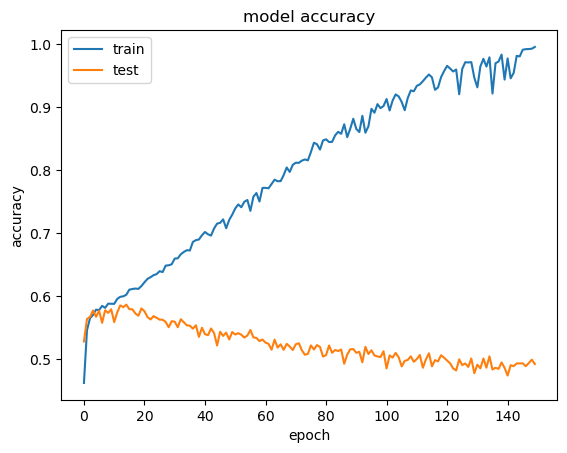

<-------------Model Loss Graph------------->


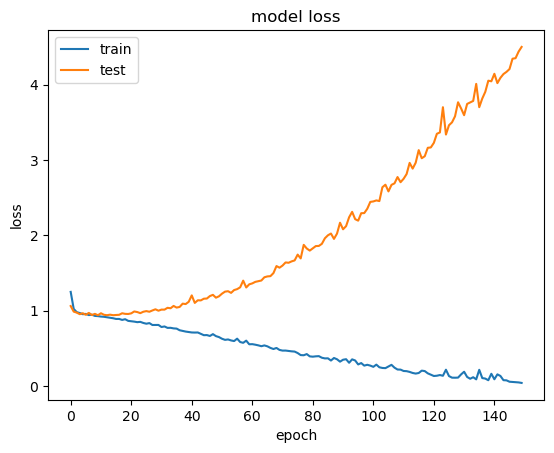

CPU times: user 933 ms, sys: 162 ms, total: 1.09 s
Wall time: 824 ms


In [35]:
%%time
print('<-------------Model Accuracy Graph------------->')
plot_model_accuracy(history6)

print('<-------------Model Loss Graph------------->')
plot_model_loss(history6)

In [36]:
%%time
print('Total time taken in training the model: %.2f seconds' % (sum(callback6.logs)))

Total time taken in training the model: 42.54 seconds
CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 59.6 µs


193/193 [==============================] - 1s 2ms/step - loss: 4.5016 - accuracy: 0.4924

Test accuracy = 0.49235522747039795 
loss - 4.501592636108398

193/193 [==============================] - 0s 2ms/step

Classification Report
               precision    recall  f1-score   support

           0       0.50      0.54      0.52       432
           1       0.30      0.28      0.29       523
           2       0.24      0.27      0.25       645
           3       0.42      0.39      0.40      1887
           4       0.64      0.66      0.65      2661

    accuracy                           0.49      6148
   macro avg       0.42      0.43      0.42      6148
weighted avg       0.49      0.49      0.49      6148


Confusion Matrix Display


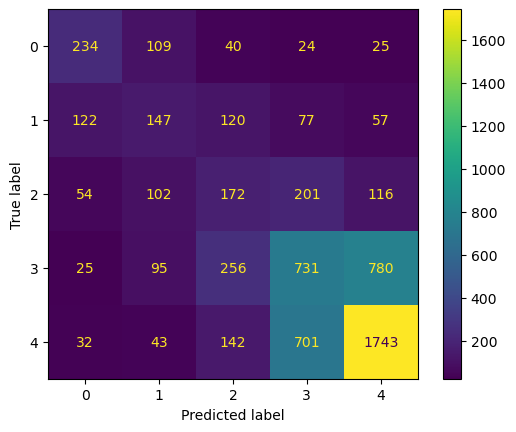

CPU times: user 1.49 s, sys: 201 ms, total: 1.69 s
Wall time: 1.49 s


In [37]:
%%time
loss6, acc6 = model6.evaluate(X_test, y_test)
print('\nTest accuracy = {} \nloss - {}\n'.format(acc6, loss6))
y_pred6 = np.argmax(model6.predict(X_test), axis=-1)
cm6 = classification_report(inverse_transformed_y_test, y_pred6)
print('\nClassification Report\n', cm6)
print('=====================================================\n')
confusion_matrix6 = confusion_matrix(inverse_transformed_y_test, y_pred6)
print('Confusion Matrix Display')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix6, display_labels=[0, 1, 2, 3, 4])
disp.plot()
plt.show()

In [38]:
%%time
q1_model_comparision.append(['Model-3', loss6, acc6])

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10.7 µs


In [39]:
%%time
calculate_total_correct_incorrect_prediction(confusion_matrix6)

CPU times: user 1.17 ms, sys: 20 µs, total: 1.19 ms
Wall time: 1.14 ms


,Rating,Correct,Correct_Perc,Incorrect,InCorrect_Perc
0,1,234,54.17%,198,45.83%
1,2,147,28.11%,376,71.89%
2,3,172,26.67%,473,73.33%
3,4,731,38.74%,1156,61.26%
4,5,1743,65.5%,918,34.5%


In [40]:
%%time
print("Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%")

Based on the above classification report, the model classified class label '5' records the best with accuracy of 87% while the worst performing class label '3' with accuracy of merely 20%
CPU times: user 1.04 ms, sys: 4 µs, total: 1.05 ms
Wall time: 844 µs


In [41]:
%%time
q1_model_comparision_df = pd.DataFrame(q1_model_comparision, columns = ['Model', 'Loss', 'Accuracy'])

CPU times: user 961 µs, sys: 0 ns, total: 961 µs
Wall time: 1.1 ms


CPU times: user 31 ms, sys: 4 ms, total: 35 ms
Wall time: 33.7 ms


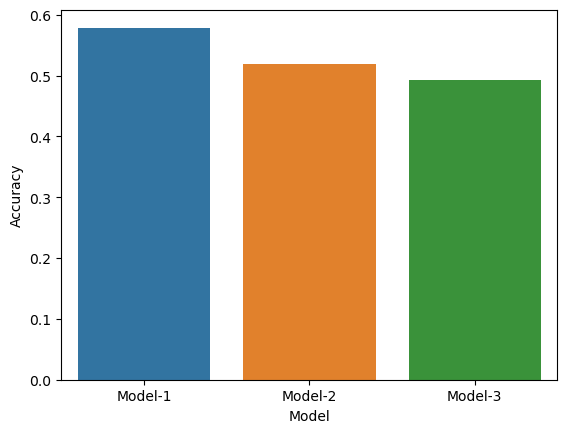

In [42]:
%%time
model2 = sns.barplot(x = 'Model', y = 'Accuracy', data = q1_model_comparision_df)

CPU times: user 34.8 ms, sys: 1.2 ms, total: 36 ms
Wall time: 35.5 ms


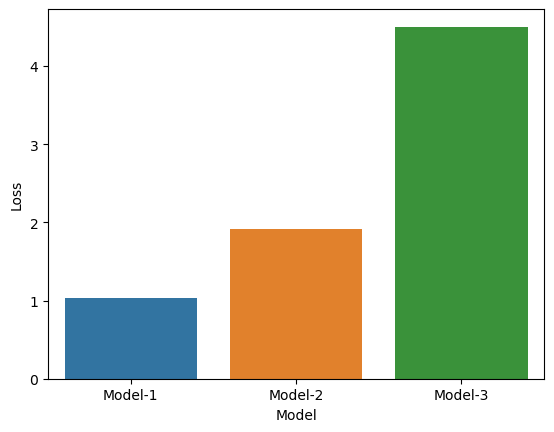

In [43]:
%%time
model1 = sns.barplot(x = 'Model', y = 'Loss', data = q1_model_comparision_df)